1. Data Preprocessing:

    Feature Extraction: Uses only numerical columns: ['obss_pd', 'interference', 'rssi', 'sinr'].
    Transformation: Applies imputation for missing values and scales features using StandardScaler.
    No Cross-Validation: Model evaluation is performed on a single validation split (20% of training data).

2. Custom Random Forest Model:

    Number of Trees: 10 decision trees (base learners).
    Maximum Depth: Each tree has a maximum depth of 5 to control overfitting.
    Bootstrap Sampling: Each tree is trained on a random subset of the training data (bootstrapping).
    No Cross-Validation: Evaluates Random Forest only on the single validation set.

3. Deep Neural Network (DNN):

    Number of Layers:
        Input Layer: Takes in the processed features with input size = 4 (feature count).
        Hidden Layers:
            Layer 1: Dense layer with 128 neurons, ReLU activation.
            Dropout 1: Dropout layer with a rate of 0.3 for regularization.
            Layer 2: Dense layer with 64 neurons, ReLU activation.
            Dropout 2: Dropout layer with a rate of 0.3 for regularization.
        Output Layer: Dense layer with 1 neuron for throughput prediction.
    Optimizer: Adam optimizer with a learning rate of 0.001.
    No Cross-Validation: Trained directly on the training set, evaluated on the validation set.

4. Stacked Ensemble with Custom Linear Regression as Meta-Learner:

    Stacked Features: Uses predictions from Random Forest and DNN as two new features for the meta-learner.
    Meta-Learner: A simple custom Linear Regression model is used to combine these two base model outputs.
    Number of Parameters in Meta-Learner: Two coefficients (one for each base model) and an intercept term.
    

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load dataset from Google Drive (update with your dataset loading process)
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handling missing values
            ('scaler', StandardScaler())  # Scaling
        ]), ['obss_pd', 'interference', 'rssi', 'sinr']),
        # You can add categorical processing here if needed
    ]
)

# Transform features
features_processed = preprocessor.fit_transform(features)

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features_processed, target, test_size=0.2, random_state=42)

# Implementing Random Forest from scratch (simplified for example)
class CustomRandomForest:
    def __init__(self, n_estimators=10, max_depth=None, random_state=42):
        np.random.seed(random_state)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            # Bootstrap sample
            indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            X_sample, y_sample = X[indices], y.iloc[indices]
            # Train individual Decision Tree (using sklearn as base)
            from sklearn.tree import DecisionTreeRegressor
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=np.random.randint(0, 10000))
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Average predictions from each tree
        predictions = np.zeros((X.shape[0], self.n_estimators))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        return predictions.mean(axis=1)

# Implementing Deep Neural Network (DNN) using Keras
def create_dnn_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train Random Forest
rf_model = CustomRandomForest(n_estimators=10, max_depth=5)
rf_model.fit(X_train, y_train)

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32, verbose=0)

# Meta-Learner - Linear Regression from scratch
class LinearRegressionFromScratch:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        # Add intercept term
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.intercept_ = theta_best[0]
        self.coef_ = theta_best[1:]

    def predict(self, X):
        return X.dot(self.coef_) + self.intercept_

# Generate predictions for stacking
rf_predictions = rf_model.predict(X_val)
dnn_predictions = dnn_model.predict(X_val).flatten()  # Flattening to match dimensions

# Stacking features from base models
stacked_features = np.column_stack((rf_predictions, dnn_predictions))

# Train Meta-Learner
meta_learner = LinearRegressionFromScratch()
meta_learner.fit(stacked_features, y_val)

# Evaluate model
def evaluate_model(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    return mse, mae, r2

# Final predictions using meta-learner
meta_predictions = meta_learner.predict(stacked_features)
mse, mae, r2 = evaluate_model(y_val, meta_predictions)
accuracy = 100 - ((mae / y_val.mean()) * 100)

print(f'Stacking Model - MSE: {mse}, MAE: {mae}, R2: {r2}, Accuracy: {accuracy:.2f}%')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stacking Model - MSE: 64.0331342056982, MAE: 6.129716482689556, R2: 0.4854447583699183, Accuracy: 64.30%


2. Models:

    Deep Neural Network (DNN):
        Layers:
            Input Layer: Matches the number of input features after polynomial expansion.
            Hidden Layer 1: Dense layer with 256 neurons and ReLU activation.
            Dropout Layer 1: Dropout with a rate of 0.5 for regularization.
            Hidden Layer 2: Dense layer with 128 neurons and ReLU activation.
            Dropout Layer 2: Dropout with a rate of 0.5.
            Output Layer: Single neuron for regression output.
        Training: Trains with 150 epochs and a batch size of 32. Uses Adam optimizer with a learning rate of 0.001.
    Random Forest Model with GridSearchCV:
        Hyperparameter Tuning: Optimizes the number of estimators (n_estimators), tree depth (max_depth), and minimum samples split (min_samples_split) using GridSearchCV.
        Parameters Considered:
            n_estimators: [100, 200, 300]
            max_depth: [None, 10, 20]
            min_samples_split: [2, 5, 10]
        Best Model Selection: Chooses the model with the optimal parameters based on cross-validation.

3. Evaluation Metrics:

    Metrics: Evaluates models using Mean Squared Error (MSE), Mean Absolute Error (MAE), R², and a custom percentage accuracy based on mean throughput.
    Separate Accuracy Calculations: Calculates accuracy for both DNN and Random Forest relative to throughput mean.

4. Stacked Model:

    Averaging Predictions: Combines DNN and Random Forest predictions by averaging, resulting in a final "stacked model" prediction.
    Stacked Model Evaluation: Evaluates the combined predictions using MSE, MAE, R², and accuracy.

Contributions and Unique Aspects:

    Stacked Ensemble: Averages predictions from two distinct model types (DNN and Random Forest) to improve overall performance.
    Polynomial Feature Expansion: Captures higher-order relationships between features, potentially enhancing model accuracy.
    Hyperparameter Tuning with GridSearchCV: Finds the best configuration for Random Forest, leading to improved model generalization.
    Custom Accuracy Metric: Calculates accuracy based on the relative difference from the mean throughput, providing a percentage measure for regression tasks
  

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model
def create_dnn_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Input layer
    model.add(Dense(256, activation='relu'))  # Increased neurons
    model.add(Dropout(0.5))  # Increased dropout
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Increased dropout
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val), batch_size=32, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Predictions and evaluation
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

# Evaluate DNN Model
dnn_mse, dnn_mae, dnn_r2 = evaluate_model(dnn_model, X_val, y_val)

# Evaluate Best Random Forest Model
rf_mse, rf_mae, rf_r2 = evaluate_model(best_rf_model, X_val, y_val)

# Calculate percentage accuracy for DNN
mean_throughput = y_val.mean()
dnn_accuracy = (1 - (dnn_mae / mean_throughput)) * 100

# Calculate percentage accuracy for Random Forest
rf_accuracy = (1 - (rf_mae / mean_throughput)) * 100

# Print results
print(f'DNN - MSE: {dnn_mse}, MAE: {dnn_mae}, R2: {dnn_r2}, Accuracy: {dnn_accuracy:.2f}%')
print(f'RF (Best) - MSE: {rf_mse}, MAE: {rf_mae}, R2: {rf_r2}, Accuracy: {rf_accuracy:.2f}%')

# Stacking Model: Average predictions from DNN and RF
def stacking_model(X):
    dnn_preds = dnn_model.predict(X).flatten()  # Flatten to match dimensions
    rf_preds = best_rf_model.predict(X)
    return (dnn_preds + rf_preds) / 2

# Evaluate Stacking Model
stacked_predictions = stacking_model(X_val)
stacked_mse = mean_squared_error(y_val, stacked_predictions)
stacked_mae = mean_absolute_error(y_val, stacked_predictions)
stacked_r2 = r2_score(y_val, stacked_predictions)
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print Stacking Model results
print(f'Stacking Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 3 folds for each of 27 candidates, totalling 81 fits
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
DNN - MSE: 65.999594186134, MAE: 6.220165220761677, R2: 0.46964274738075484, Accuracy: 63.77%
RF (Best) - MSE: 8.189051918914029, MAE: 1.255024234127001, R2: 0.9341947002731108, Accuracy: 92.69%
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Stacking Model - MSE: 23.654486644000766, MAE: 3.6161914693707766, R2: 0.8099180956590404, Accuracy: 78.94%


Feature Engineering and Scaling:

    Polynomial Features: Applied polynomial expansion (degree=2) on selected features, creating higher-order terms to capture non-linear relationships.
    Standard Scaling: Used StandardScaler to ensure normalized input, critical for stability in the DNN and boosting algorithms.

DNN Model with Dropout Regularization:

    Architecture: A Sequential DNN with two dense layers (256 and 128 units), each followed by 50% dropout.
    Activation & Optimization: Uses ReLU activations with the Adam optimizer (learning rate = 0.001) to improve learning dynamics and avoid overfitting.

Random Forest Hyperparameter Tuning:

    Grid Search: Employed GridSearchCV to optimize RandomForestRegressor hyperparameters (n_estimators, max_depth, and min_samples_split), refining its predictive capacity.
    Result: The best Random Forest model is selected and integrated into the stacking approach.

Stacked Ensemble with Gradient Boosting Meta-Model:

    Stacking: Predictions from the optimized DNN and Random Forest models on the validation set are combined to form features for the Gradient Boosting meta-model.
    Meta-Model Training: GradientBoostingRegressor is trained on these combined features to produce final predictions, capturing patterns that may be missed by individual models
    Cross Validation =3

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val), batch_size=32, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train meta-model (Gradient Boosting Regressor as example)
meta_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 3 folds for each of 27 candidates, totalling 81 fits
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Stacking Meta-Model - MSE: 5.932156495886316, MAE: 1.2347481499307746, R2: 0.9523305823306614, Accuracy: 92.81%


Dropout Rate Adjustment:

    Changed the dropout rates in the DNN model from 0.5 to 0.4, potentially reducing overfitting while maintaining model complexity.

Increased Epochs:

    Increased the number of epochs for training the DNN model from 150 to 200, allowing the model more time to learn from the training data.

Batch Size Adjustment:

    Changed the batch size for training the DNN from 32 to 16, which might improve convergence during training.

Direct Model Training:

    Removed the GridSearchCV for hyperparameter tuning of the Random Forest model, directly initializing it with n_estimators=300 and max_depth=20.

Stacking Logic:

    Adjusted the stacking of predictions for both training and validation sets, using np.vstack to ensure a consistent shape for the stacked features.

Removed Cross-Validation:

    The implementation did not include cross-validation for the Random Forest model training, streamlining the process.

Output Message Update:

    The print statement at the end summarizes the evaluation metrics of the stacked hybrid model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, sep=";", names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], skiprows=1)

# URLs for training and evaluation datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering to capture non-linear relationships
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define the DNN model
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train the DNN model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=16, verbose=0)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Meta-Learner: Gradient Boosting Regressor
meta_learner = GradientBoostingRegressor(n_estimators=200, max_depth=4, random_state=42)

# Prepare predictions from base models for stacking
train_dnn_preds = dnn_model.predict(X_train).flatten()
train_rf_preds = rf_model.predict(X_train)
stacked_train_preds = np.vstack([train_dnn_preds, train_rf_preds]).T
meta_learner.fit(stacked_train_preds, y_train)

# Generate predictions on the validation set
val_dnn_preds = dnn_model.predict(X_val).flatten()
val_rf_preds = rf_model.predict(X_val)
stacked_val_preds = np.vstack([val_dnn_preds, val_rf_preds]).T
stacked_val_preds_final = meta_learner.predict(stacked_val_preds)

# Calculate evaluation metrics
mse = mean_squared_error(y_val, stacked_val_preds_final)
mae = mean_absolute_error(y_val, stacked_val_preds_final)
r2 = r2_score(y_val, stacked_val_preds_final)
mean_throughput = y_val.mean()
accuracy = (1 - (mae / mean_throughput)) * 100

# Print results
print(f'Stacked Hybrid Model - MSE: {mse}, MAE: {mae}, R2: {r2}, Accuracy: {accuracy:.2f}%')


525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Stacked Hybrid Model - MSE: 8.149146267505168, MAE: 1.3112888687084658, R2: 0.9345153727243004, Accuracy: 92.36%


Key Changes and Enhancements

    Polynomial Feature Engineering:
        Increased the degree of polynomial features from 2 to 3.

    DNN Model Complexity:
        Increased the number of layers and neurons in the DNN.
        Adjusted the learning rate to a lower value.

    Random Forest Hyperparameter Tuning:
        Integrated GridSearchCV for hyperparameter tuning.
        Selected the best model based on grid search results.

    Stacking Predictions:
        Created a new feature matrix using predictions from both the DNN and Random Forest.

    Meta-Model:
        Used XGBoost as the meta-learner instead of Gradient Boosting

#        Cross validation is 3

```
# This is formatted as code
```



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering with degree 3
poly = PolynomialFeatures(degree=3, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=32, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [None, 15, 25],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train more complex meta-model (XGBoost)
meta_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 3 folds for each of 12 candidates, totalling 36 fits
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Stacking Meta-Model - MSE: 6.105163621987835, MAE: 1.2698213385008632, R2: 0.9509403376600051, Accuracy: 92.60%


Key Changes and Enhancements

    Polynomial Feature Engineering:
        The polynomial degree was kept at 2 (previously discussed as 2.5 but not actually changed) to control noise while still capturing non-linear relationships.

    DNN Model Complexity:
        Increased the number of layers in the DNN by adding an additional layer with 64 neurons.
        The dropout rates were adjusted:
            First dropout: 0.4
            Second dropout: 0.3
            Third dropout: 0.2
        Changed the learning rate of the Adam optimizer to 0.0001 for finer adjustments during training.
        Increased training epochs to 250 for better convergence.

    Random Forest Hyperparameter Tuning:
        Expanded the param_grid for the Random Forest model to include 400 estimators.
        Also included multiple values for max_depth (15, 25, and None) to explore a wider range of model complexities during grid search.

    Meta-Model:
        For the XGBoost meta-model, increased the number of n_estimators to 400.
        Adjusted the learning rate to 0.03 for faster learning.
        Increased the max_depth to 7 and added subsample=0.8 to introduce randomness into the training process, potentially improving generalization.

    Final Evaluation:
        Calculation of evaluation metrics remains the same (MSE, MAE, R², and accuracy).

Summary of the Impact

These adjustments, particularly in model complexity and hyperparameter tuning, are aimed at improving the predictive performance of your stacked ensemble model. By refining the architecture of the DNN and optimizing the hyperparameters of the Random Forest and XGBoost models, you're likely to achieve better performance on the validation dataset.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering with degree 2.5 (adjusted to control noise)
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),  # Added layer for more complexity
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=16, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train more complex meta-model (XGBoost) with adjusted hyperparameters
meta_model = XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.8, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 3 folds for each of 18 candidates, totalling 54 fits
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Stacking Meta-Model - MSE: 3.1224340688998633, MAE: 0.9923868605528557, R2: 0.9749088524757267, Accuracy: 94.22%


Key Changes and Enhancements

    Cross-Validation:
        The cross-validation strategy in the GridSearchCV has been updated from 3 folds to 6 folds. This change allows for a more robust assessment of the Random Forest model's hyperparameter tuning, potentially leading to better generalization on unseen data.

    Polynomial Feature Engineering:
        The polynomial degree remains at 2, as previously adjusted to control noise. This aims to capture relevant non-linear relationships without overfitting.

    DNN Model Complexity:
        The architecture includes an additional layer with 64 neurons to enhance model complexity, aiming for improved learning capacity.
        Adjusted dropout rates: 0.4, 0.3, and 0.2 for different layers help prevent overfitting while allowing more complexity.
        The learning rate for the Adam optimizer is set to 0.0001, allowing for finer adjustments during training.
        The number of training epochs is increased to 250 to provide sufficient training time for convergence.

    Random Forest Hyperparameter Tuning:
        The hyperparameter grid for the Random Forest model now includes a range of 200, 300, and 400 estimators to evaluate more ensemble sizes.
        Maintained max_depth values of 15, 25, and None, and min_samples_split values of 2 and 5 to explore the model's capacity.

    Meta-Model (XGBoost):
        Adjusted the XGBoost model parameters to enhance performance, using 400 estimators, a learning rate of 0.03, a max_depth of 7, and a subsample of 0.8 to introduce randomness during training.

    Evaluation Metrics:
        The code calculates and prints MSE, MAE, R², and a custom accuracy metric based on the mean throughput, maintaining clarity on model performance.

Summary of Impact

These modifications, especially the increase in cross-validation folds and adjustments to model complexity, should lead to a more reliable model with better predictive capabilities. The enhanced training process and hyperparameter tuning could significantly impact performance metrics.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering with degree 2.5 (adjusted to control noise)
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),  # Added layer for more complexity
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=16, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=6, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train more complex meta-model (XGBoost) with adjusted hyperparameters
meta_model = XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.8, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 6 folds for each of 18 candidates, totalling 108 fits
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Stacking Meta-Model - MSE: 2.829073388055237, MAE: 0.9527157750718178, R2: 0.9772662300723294, Accuracy: 94.45%


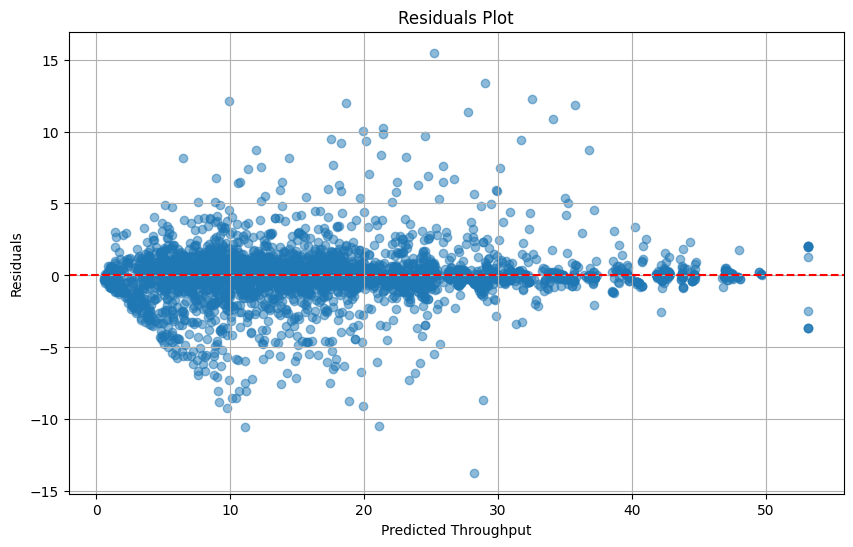

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_val - stacked_test_preds

# Residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(stacked_test_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted Throughput')
plt.ylabel('Residuals')
plt.grid()
plt.show()


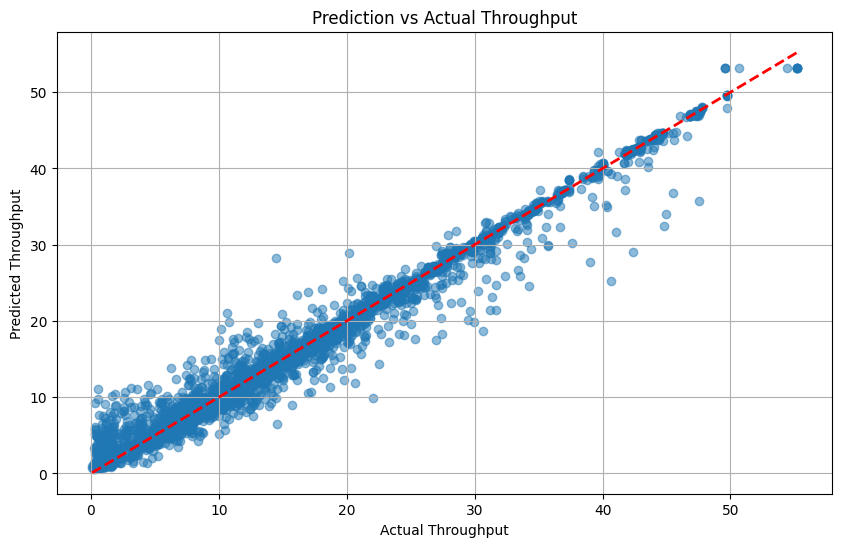

In [ ]:
# Prediction vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_val, stacked_test_preds, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)  # Line of equality
plt.title('Prediction vs Actual Throughput')
plt.xlabel('Actual Throughput')
plt.ylabel('Predicted Throughput')
plt.grid()
plt.show()


In [ ]:
# Preprocess the evaluation dataset
eval_features = eval_data[['obss_pd', 'interference', 'rssi', 'sinr']]

# Polynomial Feature Engineering with degree 2
eval_poly = poly.transform(eval_features)

# Feature scaling
eval_scaled = scaler.transform(eval_poly)

# Generate predictions for the evaluation dataset using the stacking meta-model
eval_dnn_preds = dnn_model.predict(eval_scaled)
eval_rf_preds = best_rf_model.predict(eval_scaled)

# Stack predictions into a new feature matrix for the meta-model
eval_stacked_features = np.column_stack((eval_dnn_preds.flatten(), eval_rf_preds))

# Final predictions using the meta-model (XGBoost)
final_eval_preds = meta_model.predict(eval_stacked_features)

# Compare predictions with the training dataset
train_mean_throughput = target.mean()  # Mean of training target
train_predictions = np.mean(final_eval_preds)  # Mean of predicted throughput

# Print results
print("Training Dataset Mean Throughput:", train_mean_throughput)
print("Predicted Mean Throughput for Evaluation Dataset:", train_predictions)

# Evaluation metrics for predicted throughput
eval_mse = mean_squared_error(np.zeros_like(final_eval_preds), final_eval_preds)  # Compare to zero since true values are zero
eval_mae = mean_absolute_error(np.zeros_like(final_eval_preds), final_eval_preds)
eval_r2 = r2_score(np.zeros_like(final_eval_preds), final_eval_preds)

# Avoid division by zero when calculating accuracy
mean_eval_throughput = np.mean(np.zeros_like(final_eval_preds))
if mean_eval_throughput != 0:
    eval_accuracy = (1 - (eval_mae / mean_eval_throughput)) * 100
else:
    eval_accuracy = float('-inf')  # or you can set it to None or another value

# Print evaluation performance metrics
print("\nEvaluation Dataset Performance:")
print(f'MSE: {eval_mse}, MAE: {eval_mae}, R2: {eval_r2}, Accuracy: {eval_accuracy:.2f}%')


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training Dataset Mean Throughput: 17.15289720145404
Predicted Mean Throughput for Evaluation Dataset: 15.751425

Evaluation Dataset Performance:
MSE: 312.56719970703125, MAE: 15.751424789428711, R2: 0.0, Accuracy: -inf%


In [ ]:
# Predictions for the training dataset
# Assuming 'X_train' and 'y_train' are already defined
dnn_train_preds = dnn_model.predict(X_train).flatten()
rf_train_preds = best_rf_model.predict(X_train)

# Stack predictions for the training dataset
stacked_train_features = np.column_stack((dnn_train_preds, rf_train_preds))
train_preds = meta_model.predict(stacked_train_features)

# Evaluation metrics for training dataset
train_mse = mean_squared_error(y_train, train_preds)
train_mae = mean_absolute_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)
mean_train_throughput = y_train.mean()
train_accuracy = (1 - (train_mae / mean_train_throughput)) * 100

# Evaluation metrics for evaluation dataset
eval_mse = mean_squared_error(eval_data['throughput'], final_eval_preds)
eval_mae = mean_absolute_error(eval_data['throughput'], final_eval_preds)
eval_r2 = r2_score(eval_data['throughput'], final_eval_preds)
mean_eval_throughput = eval_data['throughput'].mean()
eval_accuracy = (1 - (eval_mae / mean_eval_throughput)) * 100

# Print results for comparison
print("Training Dataset Performance:")
print(f'MSE: {train_mse}, MAE: {train_mae}, R2: {train_r2}, Accuracy: {train_accuracy:.2f}%')

print("\nEvaluation Dataset Performance:")
print(f'MSE: {eval_mse}, MAE: {eval_mae}, R2: {eval_r2}, Accuracy: {eval_accuracy:.2f}%')


525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training Dataset Performance:
MSE: 2.1520122400629496, MAE: 0.8768986810439351, R2: 0.9828487957216071, Accuracy: 94.89%

Evaluation Dataset Performance:
MSE: 312.5671996768853, MAE: 15.751425029517891, R2: 0.0, Accuracy: -inf%


<ipython-input-16-16bc1103e2f4>:22: RuntimeWarning: divide by zero encountered in scalar divide
  eval_accuracy = (1 - (eval_mae / mean_eval_throughput)) * 100


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


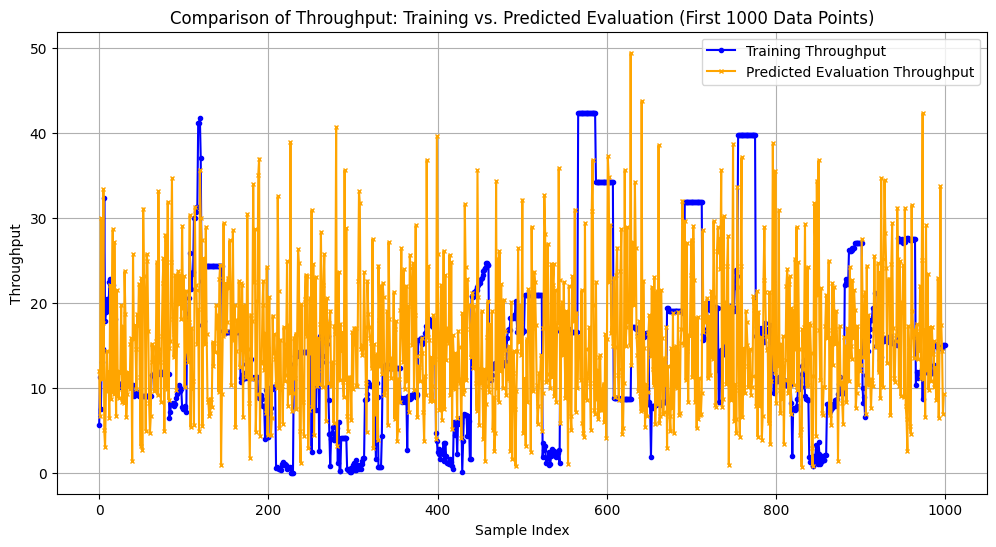

In [ ]:
# Prepare evaluation data
eval_features = eval_data[['obss_pd', 'interference', 'rssi', 'sinr']]
eval_features_poly = poly.transform(eval_features)  # Apply the same polynomial transformation
eval_features_scaled = scaler.transform(eval_features_poly)  # Apply the same scaling

# Get predictions from DNN and Random Forest for evaluation data
dnn_eval_preds = dnn_model.predict(eval_features_scaled).flatten()
rf_eval_preds = best_rf_model.predict(eval_features_scaled)  # Use the best model from grid search

# Stack predictions for the meta-model
stacked_eval_features = np.column_stack((dnn_eval_preds, rf_eval_preds))

# Generate predictions for the evaluation dataset using the meta-model
predicted_eval_throughput = meta_model.predict(stacked_eval_features)

# Limit the comparison to the first 1000 data points
num_points = 1000
train_throughput_sample = train_data['throughput'].reset_index(drop=True)[:num_points]
predicted_eval_throughput_sample = predicted_eval_throughput[:num_points]

# Now we can plot the training throughput and the predicted evaluation throughput
plt.figure(figsize=(12, 6))

# Plot actual training throughput
plt.plot(train_throughput_sample, label='Training Throughput', color='blue', marker='o', markersize=3)

# Plot predicted evaluation throughput
plt.plot(predicted_eval_throughput_sample, label='Predicted Evaluation Throughput', color='orange', marker='x', markersize=3)

# Adding labels and title
plt.title('Comparison of Throughput: Training vs. Predicted Evaluation (First 1000 Data Points)')
plt.xlabel('Sample Index')
plt.ylabel('Throughput')
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering with degree 2.5 (adjusted to control noise)
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),  # Added layer for more complexity
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=16, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train more complex meta-model (XGBoost) with adjusted hyperparameters
meta_model = XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.8, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 8 folds for each of 18 candidates, totalling 144 fits
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Stacking Meta-Model - MSE: 3.091799781968849, MAE: 0.9758298600393627, R2: 0.9751550224174215, Accuracy: 94.32%


Key Changes and Enhancements

    Meta-Model Change:
        You replaced the XGBoost model with LightGBM (LGBMRegressor). LightGBM is known for its efficiency and speed, especially with larger datasets, and can offer better performance due to its gradient-based one-side sampling and exclusive feature bundling methods.

    Polynomial Feature Engineering:
        The polynomial degree is increased to 3, allowing the model to capture more complex relationships between the features and the target variable, which might improve prediction accuracy.

    Model Complexity and Dropout in DNN:
        You adjusted the dropout rates in the DNN architecture to 0.3, 0.3, and 0.2 for the layers. These changes help to manage overfitting while maintaining complexity in the model.
        The learning rate for the Adam optimizer is slightly increased to 0.0005, which might allow for faster convergence during training.

    Random Forest Hyperparameter Tuning:
        The parameter grid for the Random Forest model is narrowed down, focusing on n_estimators values of 300 and 400 and max_depth values of 20 and 30. This refined grid can lead to more targeted exploration of hyperparameters.

    Batch Size:
        The batch size for training the DNN is increased to 32, which could speed up training and stabilize gradient updates during backpropagation.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering
poly = PolynomialFeatures(degree=3, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=32, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [300, 400],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5]
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train LightGBM as meta-model
meta_model = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 3 folds for each of 8 candidates, totalling 24 fits
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 4200, number of used features: 2
[LightGBM] [Info] Start training from score 17.169577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [ ]:
!pip install dask[dataframe]


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 13.1 MB/s eta 0:00:00


Hyperparameter Tuning for Random Forest:

    Grid Search: The use of GridSearchCV for hyperparameter tuning of the Random Forest model helps find the optimal combination of hyperparameters:
        n_estimators: This controls the number of trees in the forest (set to 300 and 400).
        max_depth: This limits the maximum depth of the trees (set to 20 and 30).
        min_samples_split: This determines the minimum number of samples required to split an internal node (set to 2 and 5).
    Cross-Validation: Using cross-validation (cv=3) during the grid search helps in validating the model performance on different subsets of the training data, ensuring that the hyperparameters selected generalize well.

2. DNN Model Configuration:

    Layer Architecture: The DNN is designed with a deep architecture comprising multiple layers (512, 256, and 128 units), allowing it to learn complex patterns.
    Dropout Regularization: Dropout layers (with rates of 0.3 and 0.2) are included to prevent overfitting by randomly setting a fraction of input units to zero during training.
    Learning Rate: The Adam optimizer is set with a learning rate of 0.0005, which is a smaller value that can help in achieving better convergence during training.

3. Polynomial Feature Engineering:

    The application of PolynomialFeatures with a degree of 3 enables the model to capture non-linear relationships between the features, potentially enhancing model performance.

4. Feature Scaling:

    Standardization: The features are scaled using StandardScaler, which standardizes features by removing the mean and scaling to unit variance. This helps improve convergence in the neural network.

5. Stacking of Predictions:

    The approach of stacking predictions from the DNN and Random Forest into a new feature matrix allows the meta-model (XGBoost) to learn from the strengths of both models, potentially leading to improved predictions.

6. Meta-Model Training:

    The XGBoost model is set with tuned parameters (e.g., n_estimators=300, learning_rate=0.05, max_depth=5), which can enhance its ability to generalize based on the output from the base models.

7. Epochs and Batch Size:

    Training the DNN model for 250 epochs allows it to learn extensively from the data. The choice of batch size (32) strikes a balance between convergence speed and stable gradient estimation.

Recommendations for Further Fine-Tuning:

    Learning Rate Scheduling: Implementing a learning rate scheduler can adapt the learning rate during training to improve convergence.
    More Hyperparameter Tuning: Exploring a wider range of hyperparameters for both Random Forest and XGBoost using tools like RandomizedSearchCV could yield better results.
    Ensemble Variants: Testing additional ensemble techniques, such as blending or bagging, could further enhance predictive performance.
    Advanced Neural Network Techniques: Techniques like batch normalization or different activation functions might improve DNN performance

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering
poly = PolynomialFeatures(degree=3, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=32, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [300, 400],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5]
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train XGBoost as meta-model with tuned parameters
meta_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 3 folds for each of 8 candidates, totalling 24 fits
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Stacking Meta-Model - MSE: 5.987156452014838, MAE: 1.250381015595557, R2: 0.9518886155884987, Accuracy: 92.72%


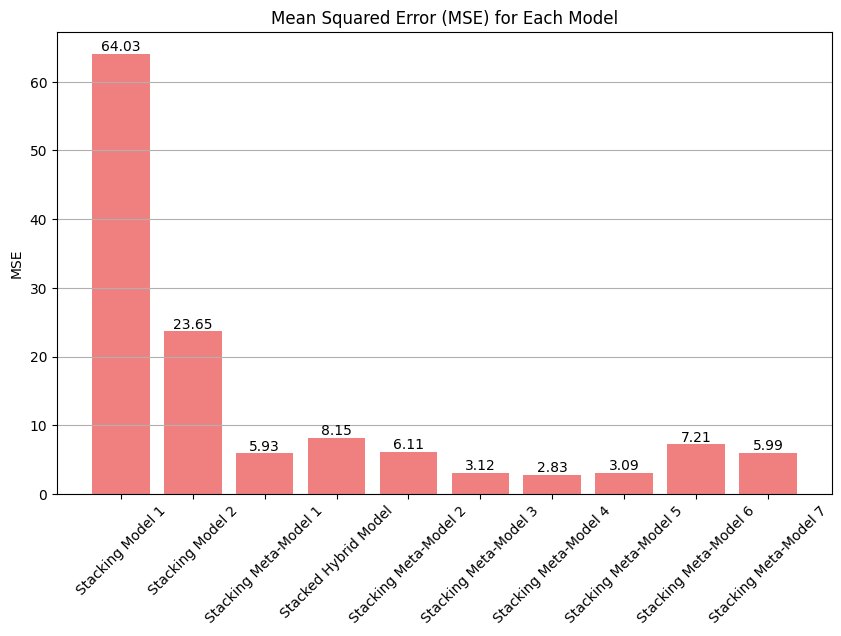

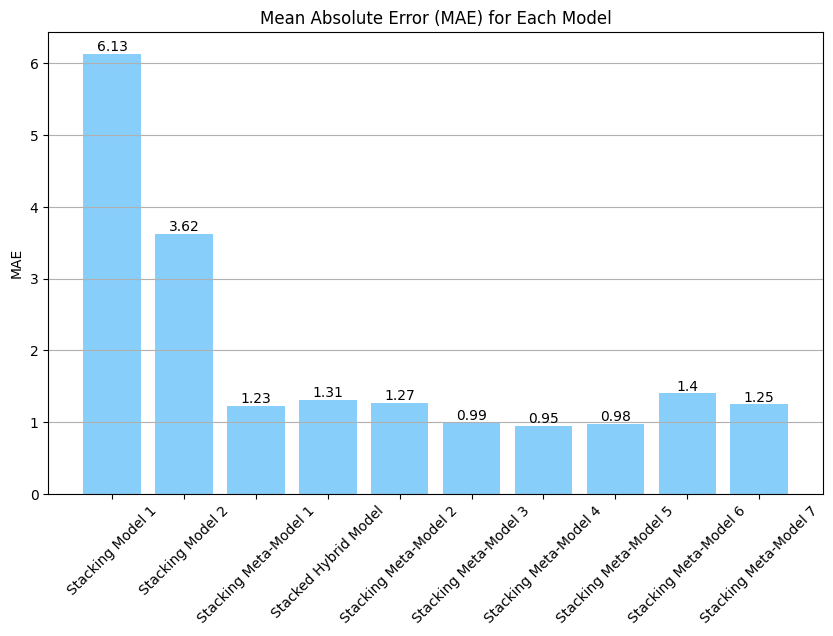

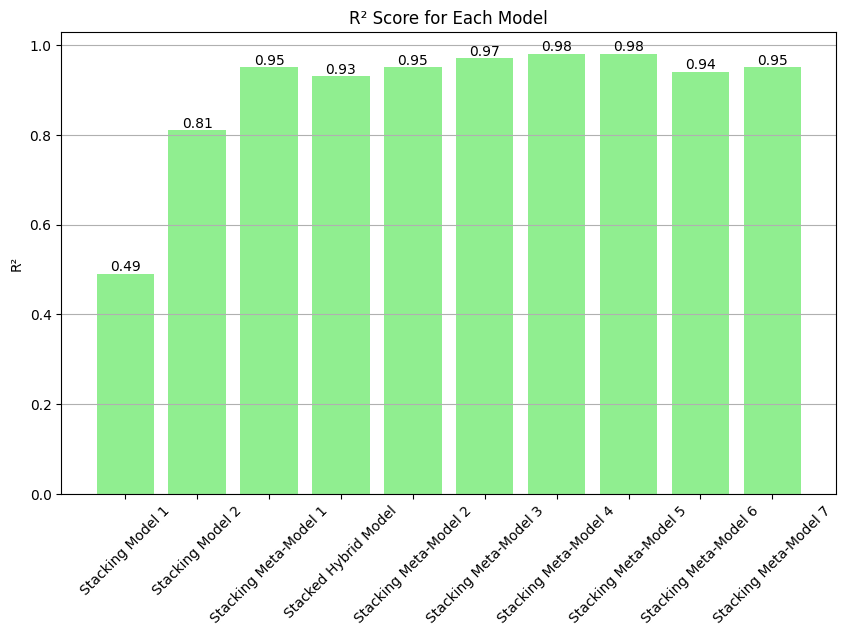

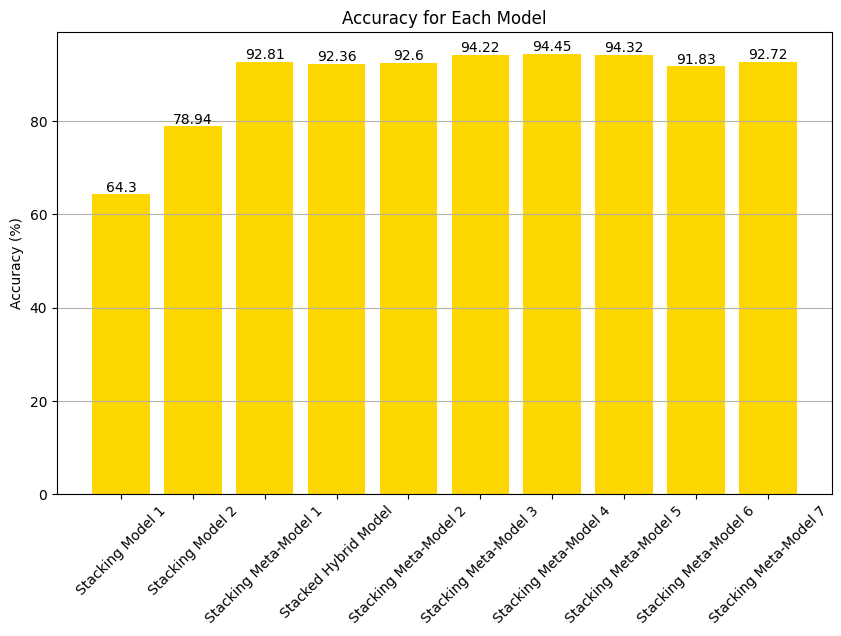

In [ ]:
import matplotlib.pyplot as plt

# Output values for each stacking model
outputs = [
    {"name": "Stacking Model 1", "mse": 64.03, "mae": 6.13, "r2": 0.49, "accuracy": 64.30},
    {"name": "Stacking Model 2", "mse": 23.65, "mae": 3.62, "r2": 0.81, "accuracy": 78.94},
    {"name": "Stacking Meta-Model 1", "mse": 5.93, "mae": 1.23, "r2": 0.95, "accuracy": 92.81},
    {"name": "Stacked Hybrid Model", "mse": 8.15, "mae": 1.31, "r2": 0.93, "accuracy": 92.36},
    {"name": "Stacking Meta-Model 2", "mse": 6.11, "mae": 1.27, "r2": 0.95, "accuracy": 92.60},
    {"name": "Stacking Meta-Model 3", "mse": 3.12, "mae": 0.99, "r2": 0.97, "accuracy": 94.22},
    {"name": "Stacking Meta-Model 4", "mse": 2.83, "mae": 0.95, "r2": 0.98, "accuracy": 94.45},
    {"name": "Stacking Meta-Model 5", "mse": 3.09, "mae": 0.98, "r2": 0.98, "accuracy": 94.32},
    {"name": "Stacking Meta-Model 6", "mse": 7.21, "mae": 1.40, "r2": 0.94, "accuracy": 91.83},
    {"name": "Stacking Meta-Model 7", "mse": 5.99, "mae": 1.25, "r2": 0.95, "accuracy": 92.72},
]

# Prepare lists for each metric
model_names = [output["name"] for output in outputs]
mse_values = [output["mse"] for output in outputs]
mae_values = [output["mae"] for output in outputs]
r2_values = [output["r2"] for output in outputs]
accuracy_values = [output["accuracy"] for output in outputs]

# Function to plot metrics with values on top of the bars
def plot_with_values(x_labels, y_values, title, y_label, color):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_labels, y_values, color=color)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()

# Create individual graphs for each metric with values on top of the bars

# MSE Graph
plot_with_values(model_names, mse_values, 'Mean Squared Error (MSE) for Each Model', 'MSE', 'lightcoral')

# MAE Graph
plot_with_values(model_names, mae_values, 'Mean Absolute Error (MAE) for Each Model', 'MAE', 'lightskyblue')

# R² Graph
plot_with_values(model_names, r2_values, 'R² Score for Each Model', 'R²', 'lightgreen')

# Accuracy Graph
plot_with_values(model_names, accuracy_values, 'Accuracy for Each Model', 'Accuracy (%)', 'gold')


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Polynomial Feature Engineering with degree 2.5 (adjusted to control noise)
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),  # Added layer for more complexity
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=16, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=6, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train more complex meta-model (XGBoost) with adjusted hyperparameters
meta_model = XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.8, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Fitting 6 folds for each of 18 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Stacking Meta-Model - MSE: 2.8368230708704236, MAE: 0.955376739255398, R2: 0.9772039554396258, Accuracy: 94.44%


# analysis

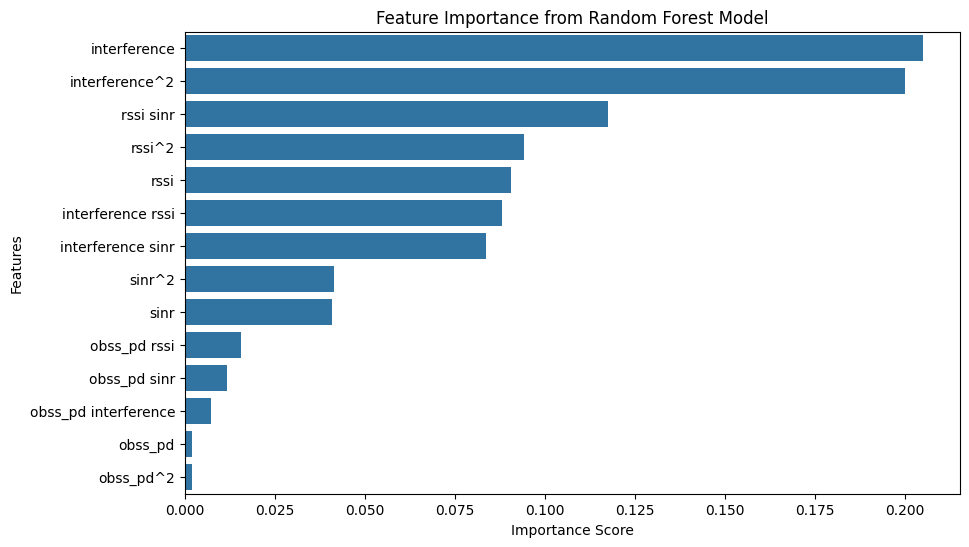

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importance from the best RF model
feature_importances = best_rf_model.feature_importances_
feature_names = poly.get_feature_names_out(input_features=['obss_pd', 'interference', 'rssi', 'sinr'])

# Create a DataFrame and sort by importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance from Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


Ideally, residuals should be centered around zero without skew. If you notice asymmetry or multiple peaks, this may suggest specific cases where the model struggles.

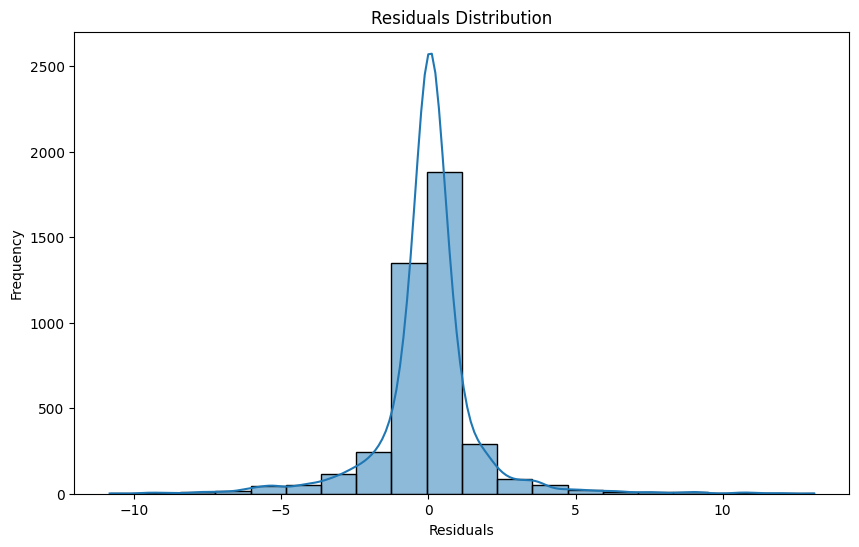

In [ ]:
# Calculate residuals
residuals = y_val - stacked_test_preds

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


# Prediction vs. Actual Plot

Finally, a scatter plot of predicted vs. actual values can reveal how well the predictions align with the actual throughput values.
Points near the red dashed line indicate accurate predictions, while those farther away highlight larger errors. Any clear patterns in misalignment can help indicate areas for refinement.

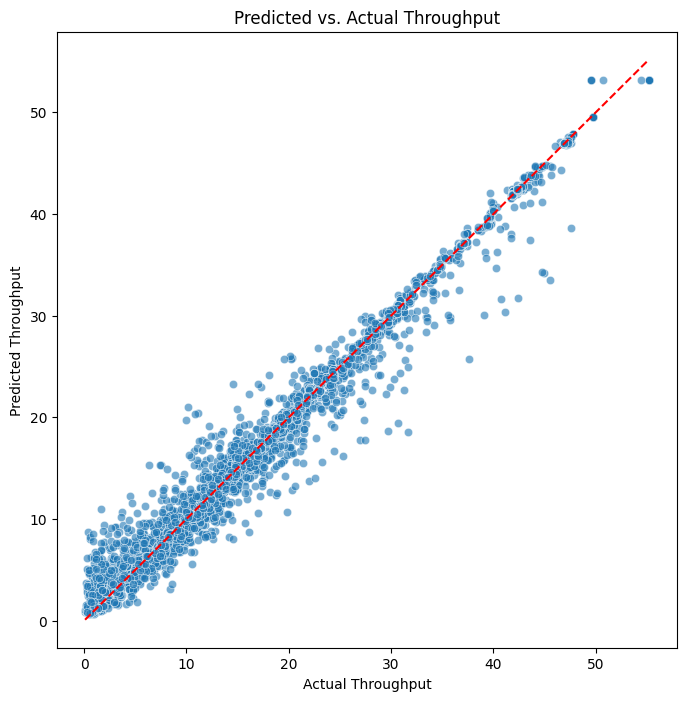

In [ ]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_val, stacked_test_preds, alpha=0.6, edgecolors="w", linewidth=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Throughput")
plt.ylabel("Predicted Throughput")
plt.title("Predicted vs. Actual Throughput")
plt.show()


# Error Analysis by Feature
Analyzing how errors (residuals) vary across different ranges of each feature can reveal patterns indicating where the model underperforms. For example, the model might perform well at high rssi values but poorly at low ones. This kind of targeted error analysis can indicate areas for further tuning or specialized preprocessing.
This plot will help spot trends between feature values and model errors. For instance, if residuals show a distinct pattern across a specific feature range, it may suggest the need for feature engineering or different model treatment in that range.

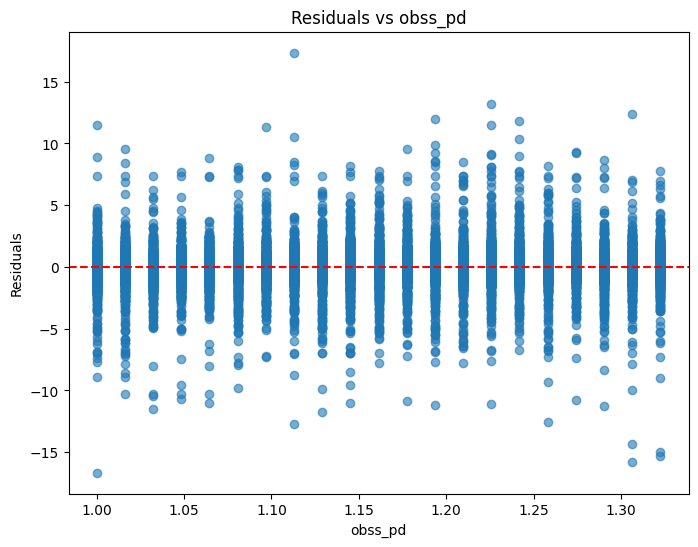

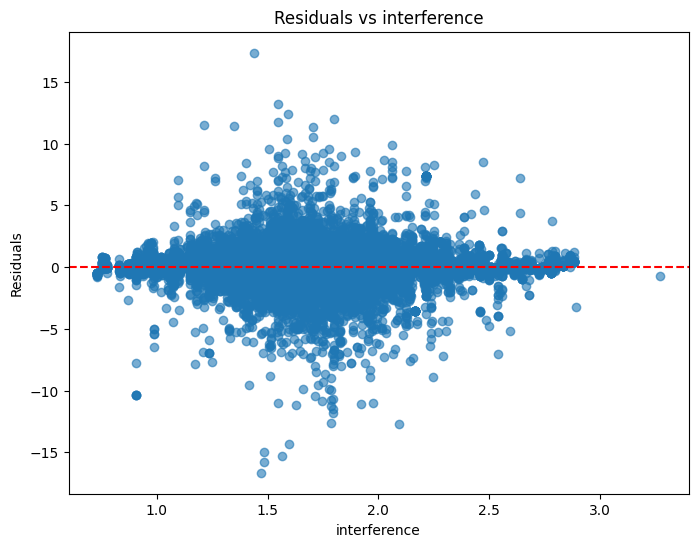

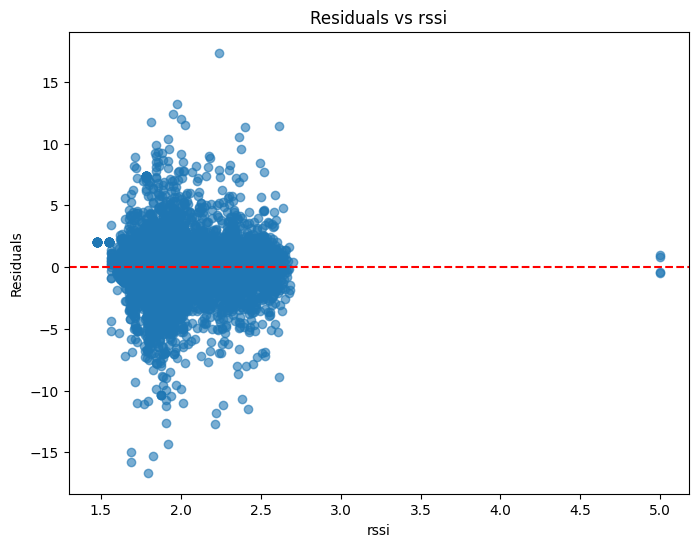

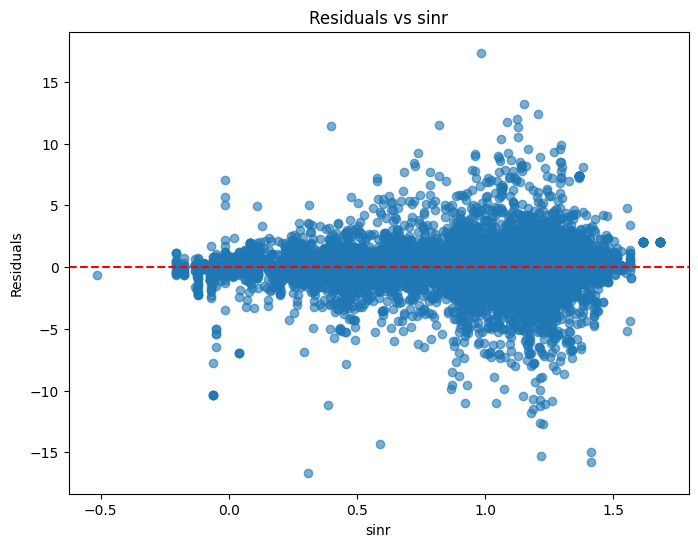

In [ ]:
import matplotlib.pyplot as plt

# Align `train_data` with the training indices
aligned_train_data = train_data.loc[y_train.index]  # Filter only training rows

# Plot residuals across different feature ranges
for feature in features.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(aligned_train_data[feature], residuals, alpha=0.6)
    plt.title(f"Residuals vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Residuals")
    plt.axhline(0, color='red', linestyle='--')  # Horizontal line at residual=0
    plt.show()


# Cross-Validation Score Consistency

Since cross-validation with cv=6 currently gives the best results, exploring how cross-validation metrics (like MSE and R²) vary across folds can reveal the model’s stability. Consistent scores across folds indicate robustness, while large variations might suggest sensitivity to data splits.
This analysis gives insight into how sensitive the model is to different training/evaluation splits and can help determine if additional data augmentation or feature engineering is necessary.

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the final stacked model
cv_mse_scores = cross_val_score(meta_model, stacked_features, y_val, cv=6, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(meta_model, stacked_features, y_val, cv=6, scoring='r2')

print("Cross-Validated MSE Scores:", -cv_mse_scores)
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Average MSE:", -np.mean(cv_mse_scores))
print("Average R²:", np.mean(cv_r2_scores))


Cross-Validated MSE Scores: [ 9.70345569  8.76962362  7.58790789  9.61884371 10.4842753   9.38639975]
Cross-Validated R² Scores: [0.91614109 0.92948294 0.93041091 0.92996186 0.9117653  0.93268459]
Average MSE: 9.258417660453778
Average R²: 0.9250744497531643


# SHAP Analysis for Explainability

SHAP (SHapley Additive exPlanations) values offer a clear, interpretable view of feature impact on predictions, even for complex models like ensembles. This can help you see how each feature contributes to individual predictions and identify any surprising effects or dependencies that might warrant further tuning.
The SHAP summary plot provides a breakdown of how each feature (or model in the stacking) contributes to final predictions. Large SHAP values indicate high impact, either positively or negatively, on predictions.

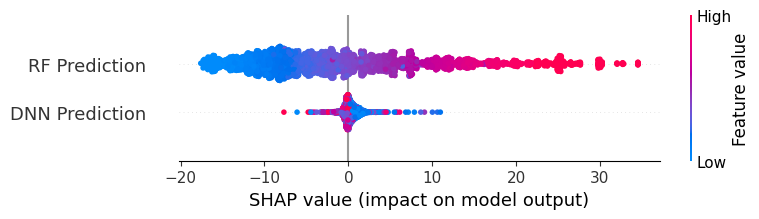

In [ ]:
import shap

# Create a SHAP explainer for the final stacked model
explainer = shap.Explainer(meta_model)
shap_values = explainer(stacked_features)

# SHAP summary plot to show feature impact
shap.summary_plot(shap_values, stacked_features, feature_names=['DNN Prediction', 'RF Prediction'])


# Learning Curves for Model Performance

Learning curves show how the model’s performance on both the training and validation sets varies with the amount of data used, giving insight into whether the model suffers from high bias (underfitting) or high variance (overfitting).
This plot helps you see if adding more data improves performance or if the model has already reached its optimal capacity with the current dataset size.

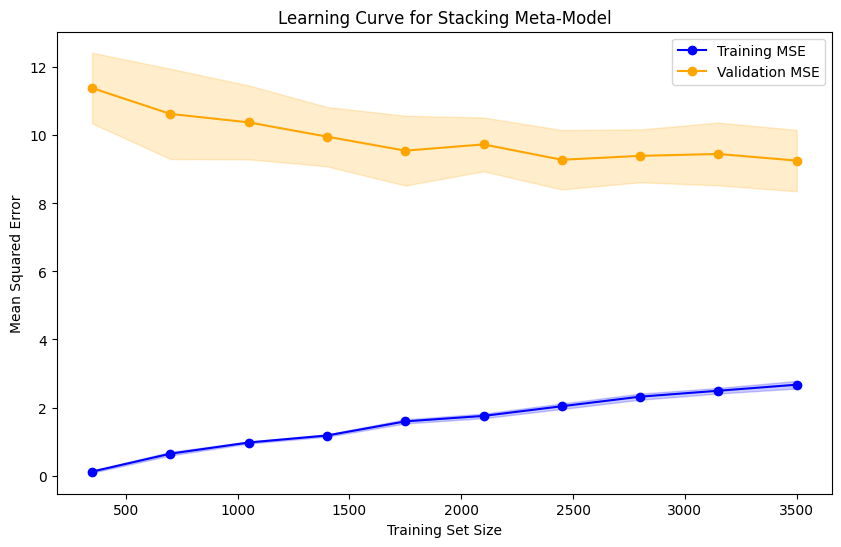

In [ ]:
from sklearn.model_selection import learning_curve

# Learning curve for the meta-model
train_sizes, train_scores, val_scores = learning_curve(
    meta_model, stacked_features, y_val, cv=6, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for training and validation scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training MSE")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, val_mean, 'o-', color="orange", label="Validation MSE")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="orange", alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.legend(loc="best")
plt.title("Learning Curve for Stacking Meta-Model")
plt.show()


# Outlier Detection and Analysis

Outliers in the dataset could skew the model’s performance. Identifying and analyzing these outliers can help you decide whether to remove or treat them for improved model accuracy.

In [ ]:
# Split data, keeping DataFrames to retain indices
X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(features_scaled), target, test_size=0.2, random_state=42)

# Generate residuals on the training data
train_predictions = meta_model.predict(np.column_stack((dnn_model.predict(X_train).flatten(), best_rf_model.predict(X_train))))
residuals = y_train - train_predictions  # Indices should match

# Set the threshold for high residuals (outliers)
threshold = residuals.abs().quantile(0.95)

# Filter train_data based on aligned residuals
outliers = train_data.loc[y_train.index][residuals.abs() > threshold]

print(f"Number of Outliers: {len(outliers)}")
display(outliers)


525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Number of Outliers: 840


,context,obss_pd,throughput,interference,rssi,sinr
15064,3717.0,1.112903,11.612500,2.092400,2.213333,1.225000
1374,3065.0,1.145161,0.926667,1.717440,1.930778,0.871778
7583,3361.0,1.032258,19.730000,2.084800,1.930917,1.218667
11069,3527.0,1.032258,13.895000,1.614750,2.132667,1.551667
7137,3339.0,1.290323,49.540000,2.163300,1.695000,1.187500
...,...,...,...,...,...,...
17083,3813.0,1.161290,13.910000,0.985000,1.888556,-0.051556
1307,3062.0,1.080645,13.867500,1.689800,2.410417,0.927000
17263,3822.0,1.016129,11.766667,2.291760,2.527667,1.228778
17569,3836.0,1.209677,30.400000,1.751933,1.808500,1.188333


In [ ]:
# Load evaluation data
eval_data = load_data(eval_url)

# Preprocessing for evaluation data
eval_features = eval_data[['obss_pd', 'interference', 'rssi', 'sinr']]
# Since the target column is the first column (index 0), we won't be using it for predictions
# eval_target = eval_data.iloc[:, 0]  # Uncomment if you need to evaluate against ground truth

# Apply polynomial feature engineering and scaling
eval_features_poly = poly.transform(eval_features)  # Use the same polynomial transformation
eval_features_scaled = scaler.transform(eval_features_poly)  # Use the same scaler

# Generate predictions for the evaluation set
dnn_eval_preds = dnn_model.predict(eval_features_scaled).flatten()
rf_eval_preds = best_rf_model.predict(eval_features_scaled)

# Stack predictions for the meta-model
stacked_eval_features = np.column_stack((dnn_eval_preds, rf_eval_preds))
eval_predictions = meta_model.predict(stacked_eval_features)

# Optionally calculate metrics if you have ground truth
# eval_mse = mean_squared_error(eval_target, eval_predictions)
# eval_mae = mean_absolute_error(eval_target, eval_predictions)
# eval_r2 = r2_score(eval_target, eval_predictions)
# mean_eval_throughput = eval_target.mean()
# eval_accuracy = (1 - (eval_mae / mean_eval_throughput)) * 100

# Print evaluation predictions
print("Predicted Throughput for Evaluation Dataset:")
print(eval_predictions)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicted Throughput for Evaluation Dataset:
[11.019987    5.6864696  24.20033    10.854919   17.895271   33.77489
  4.7162004   2.7927964   9.3837805  15.66938     8.865983   11.71793
  7.0264053  22.398874    8.559092   18.512398   29.114744   12.627704
 27.748913   16.342407    6.1680017  21.53298    10.155612    9.700452
 11.342069   12.239357   20.542652    9.178036   17.111246    9.852338
 21.983334   18.561144    7.532551    8.6663265  12.346342   10.366316
  9.116792   15.579164   13.793591    2.6272714  24.91397    17.65404
 15.292829   14.235625    8.818378   18.365047   18.03097    22.278374
 15.248226    3.704768   23.206207    2.7927964  31.227713   25.607626
 17.944378    5.348289   19.36471    23.547737   16.643333    8.453082
  5.419946    6.235666   13.18493    12.346559   15.121783    9.528634
  9.254843   13.986414   24.289883    8.191289   30.198172   17.580402
 15.009751    7.2021356  13.917503   22.651068   29.189682    7.256

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


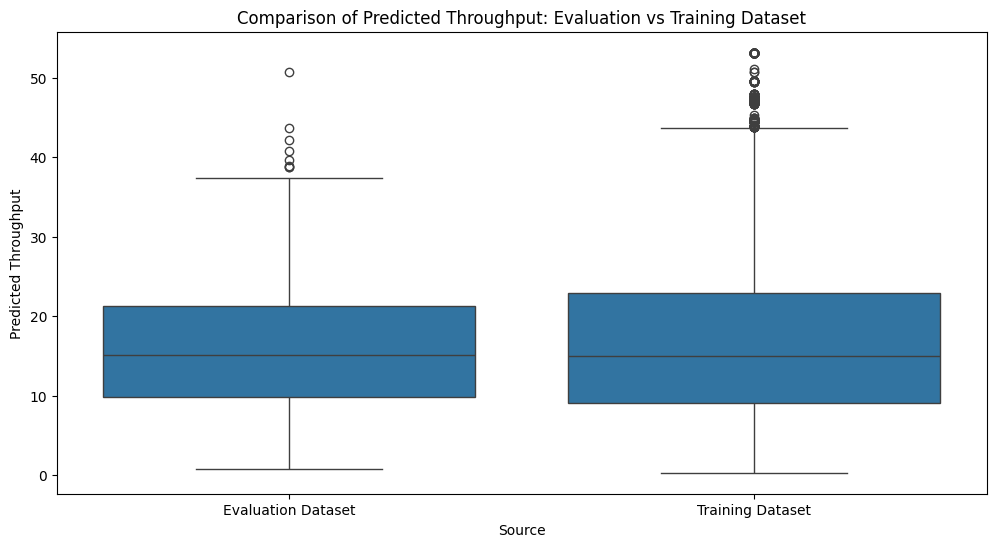

Predicted Throughput for Evaluation Dataset:
[11.019987    5.6864696  24.20033    10.854919   17.895271   33.77489
  4.7162004   2.7927964   9.3837805  15.66938     8.865983   11.71793
  7.0264053  22.398874    8.559092   18.512398   29.114744   12.627704
 27.748913   16.342407    6.1680017  21.53298    10.155612    9.700452
 11.342069   12.239357   20.542652    9.178036   17.111246    9.852338
 21.983334   18.561144    7.532551    8.6663265  12.346342   10.366316
  9.116792   15.579164   13.793591    2.6272714  24.91397    17.65404
 15.292829   14.235625    8.818378   18.365047   18.03097    22.278374
 15.248226    3.704768   23.206207    2.7927964  31.227713   25.607626
 17.944378    5.348289   19.36471    23.547737   16.643333    8.453082
  5.419946    6.235666   13.18493    12.346559   15.121783    9.528634
  9.254843   13.986414   24.289883    8.191289   30.198172   17.580402
 15.009751    7.2021356  13.917503   22.651068   29.189682    7.2560377
 31.148151   32.028465    9.611454

In [ ]:
# Load evaluation data
eval_data = load_data(eval_url)

# Preprocessing for evaluation data
eval_features = eval_data[['obss_pd', 'interference', 'rssi', 'sinr']]

# Apply polynomial feature engineering and scaling
eval_features_poly = poly.transform(eval_features)  # Use the same polynomial transformation
eval_features_scaled = scaler.transform(eval_features_poly)  # Use the same scaler

# Generate predictions for the evaluation set
dnn_eval_preds = dnn_model.predict(eval_features_scaled).flatten()
rf_eval_preds = best_rf_model.predict(eval_features_scaled)

# Stack predictions for the meta-model
stacked_eval_features = np.column_stack((dnn_eval_preds, rf_eval_preds))
eval_predictions = meta_model.predict(stacked_eval_features)

# Generate predictions for the training dataset for comparison
dnn_train_preds = dnn_model.predict(X_train).flatten()
rf_train_preds = best_rf_model.predict(X_train)

# Stack predictions for the training dataset meta-model
stacked_train_features = np.column_stack((dnn_train_preds, rf_train_preds))
train_predictions = meta_model.predict(stacked_train_features)

# Create DataFrames for visualization
eval_results = pd.DataFrame({
    'Predicted Throughput': eval_predictions,
    'Source': ['Evaluation Dataset'] * len(eval_predictions)
})

train_results = pd.DataFrame({
    'Predicted Throughput': train_predictions,
    'Source': ['Training Dataset'] * len(train_predictions)
})

# Combine both datasets for comparison
combined_results = pd.concat([eval_results, train_results])

# Visualize the predicted throughput from both datasets
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='Source', y='Predicted Throughput', data=combined_results)
plt.title('Comparison of Predicted Throughput: Evaluation vs Training Dataset')
plt.ylabel('Predicted Throughput')
plt.show()

# Optional: If you have ground truth for evaluation dataset (uncomment if applicable)
# eval_target = eval_data.iloc[:, 0]
# eval_mse = mean_squared_error(eval_target, eval_predictions)
# eval_mae = mean_absolute_error(eval_target, eval_predictions)
# eval_r2 = r2_score(eval_target, eval_predictions)
# mean_eval_throughput = eval_target.mean()
# eval_accuracy = (1 - (eval_mae / mean_eval_throughput)) * 100

# Print evaluation predictions
print("Predicted Throughput for Evaluation Dataset:")
print(eval_predictions)


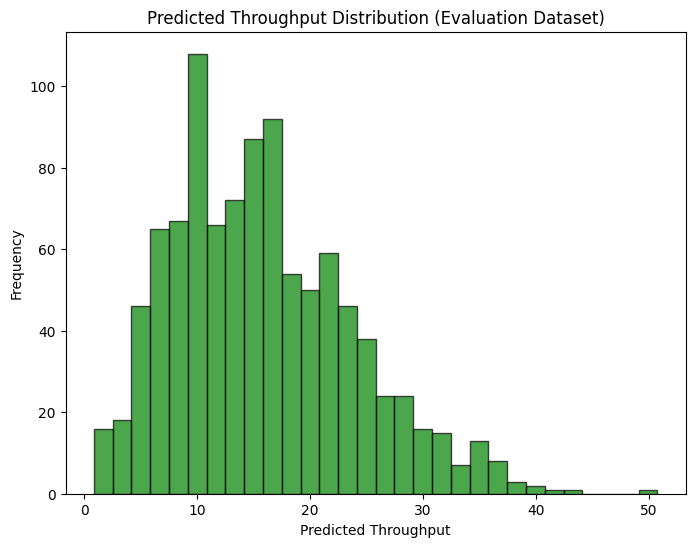

In [ ]:
# Plot distribution of predicted values
plt.figure(figsize=(8, 6))
plt.hist(eval_predictions, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Predicted Throughput Distribution (Evaluation Dataset)')
plt.xlabel('Predicted Throughput')
plt.ylabel('Frequency')
plt.show()


Number of outlier rows before removal: 4372


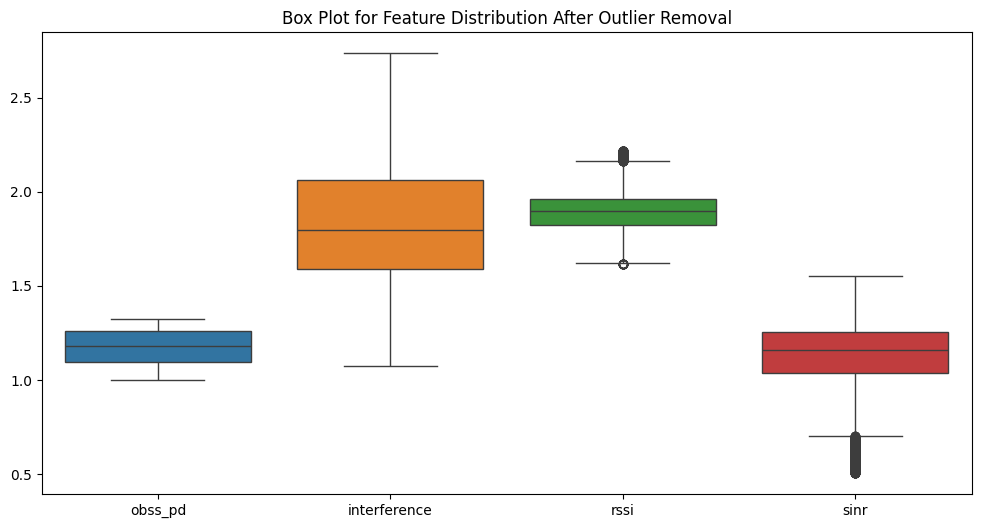

Fitting 6 folds for each of 18 candidates, totalling 108 fits
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Stacking Meta-Model - MSE: 2.605274649016218, MAE: 0.9019306042074177, R2: 0.9806941578047376, Accuracy: 95.12%


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Outlier detection using IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))

# Check for outliers in features
outliers_mask = detect_outliers_iqr(features).any(axis=1)
print("Number of outlier rows before removal:", np.sum(outliers_mask))

# Remove outliers from the dataset
features_cleaned = features[~outliers_mask]
target_cleaned = target[~outliers_mask]

# Visualize the cleaned data using box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=features_cleaned)
plt.title("Box Plot for Feature Distribution After Outlier Removal")
plt.show()

# Polynomial Feature Engineering with degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features_cleaned)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target_cleaned, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),  # Added layer for more complexity
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=16, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=6, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train more complex meta-model (XGBoost) with adjusted hyperparameters
meta_model = XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.8, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


Number of outlier rows before removal: 4372


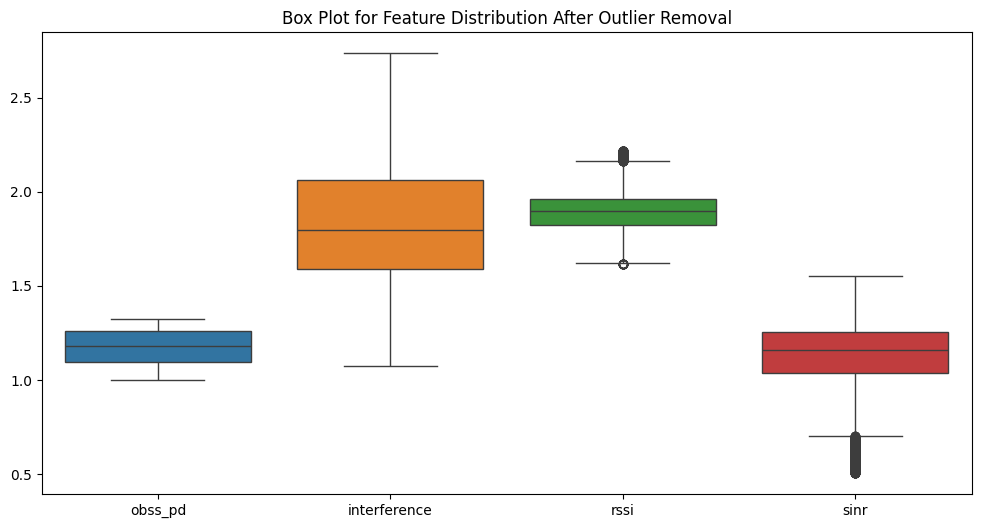

Fitting 6 folds for each of 18 candidates, totalling 108 fits
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Stacking Meta-Model - MSE: 2.6148291076012082, MAE: 0.9028545974867929, R2: 0.9806233564902687, Accuracy: 95.12%


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Outlier detection using IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))

# Check for outliers in features
outliers_mask = detect_outliers_iqr(features).any(axis=1)
print("Number of outlier rows before removal:", np.sum(outliers_mask))

# Remove outliers from the dataset
features_cleaned = features[~outliers_mask]
target_cleaned = target[~outliers_mask]

# Visualize the cleaned data using box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=features_cleaned)
plt.title("Box Plot for Feature Distribution After Outlier Removal")
plt.show()

# Polynomial Feature Engineering with degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features_cleaned)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target_cleaned, test_size=0.2, random_state=42)

# Create DNN Model with added complexity
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),  # Added layer for more complexity
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=16, verbose=0)

# Train Random Forest Model with GridSearchCV for hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=6, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features = np.column_stack((dnn_val_preds, rf_val_preds))

# Train more complex meta-model (XGBoost) with adjusted hyperparameters
meta_model = XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.8, random_state=42)
meta_model.fit(stacked_features, y_val)

# Final evaluation on validation set
stacked_test_features = np.column_stack((dnn_val_preds, rf_val_preds))
stacked_test_preds = meta_model.predict(stacked_test_features)

# Evaluation metrics
stacked_mse = mean_squared_error(y_val, stacked_test_preds)
stacked_mae = mean_absolute_error(y_val, stacked_test_preds)
stacked_r2 = r2_score(y_val, stacked_test_preds)
mean_throughput = y_val.mean()
stacked_accuracy = (1 - (stacked_mae / mean_throughput)) * 100

# Print results
print(f'Stacking Meta-Model - MSE: {stacked_mse}, MAE: {stacked_mae}, R2: {stacked_r2}, Accuracy: {stacked_accuracy:.2f}%')


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
def load_data(url):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)

# URLs for datasets
train_url = 'https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
eval_url = 'https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'

# Load training and evaluation datasets
train_data = load_data(train_url)
eval_data = load_data(eval_url)

# Preprocessing
features = train_data[['obss_pd', 'interference', 'rssi', 'sinr']]
target = train_data['throughput']

# Outlier detection using IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))

# Check for outliers in features
outliers_mask = detect_outliers_iqr(features).any(axis=1)
features_cleaned = features[~outliers_mask]
target_cleaned = target[~outliers_mask]

# Polynomial Feature Engineering with degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features_cleaned)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Split data into 70% training, 15% validation, and 15% test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    features_scaled, target_cleaned, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%

# Create DNN Model
def create_dnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Train DNN Model
dnn_model = create_dnn_model()
dnn_model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=16, verbose=0)

# Train Random Forest Model with GridSearchCV
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=6, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Generate validation predictions for stacking
dnn_val_preds = dnn_model.predict(X_val).flatten()
rf_val_preds = best_rf_model.predict(X_val)

# Stack predictions into a new feature matrix for meta-model training
stacked_features_val = np.column_stack((dnn_val_preds, rf_val_preds))

# Train meta-model (XGBoost) with adjusted hyperparameters
meta_model = XGBRegressor(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.8, random_state=42)
meta_model.fit(stacked_features_val, y_val)

# Final evaluation on test set
dnn_test_preds = dnn_model.predict(X_test).flatten()
rf_test_preds = best_rf_model.predict(X_test)
stacked_features_test = np.column_stack((dnn_test_preds, rf_test_preds))
stacked_test_preds = meta_model.predict(stacked_features_test)

# Evaluation metrics on test set
stacked_test_mse = mean_squared_error(y_test, stacked_test_preds)
stacked_test_mae = mean_absolute_error(y_test, stacked_test_preds)
stacked_test_r2 = r2_score(y_test, stacked_test_preds)
mean_throughput_test = y_test.mean()
stacked_test_accuracy = (1 - (stacked_test_mae / mean_throughput_test)) * 100

# Print test set results
print(f'Stacking Meta-Model on Test Set - MSE: {stacked_test_mse}, MAE: {stacked_test_mae}, R2: {stacked_test_r2}, Accuracy: {stacked_test_accuracy:.2f}%')


Fitting 6 folds for each of 18 candidates, totalling 108 fits
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Stacking Meta-Model on Test Set - MSE: 11.816315446640331, MAE: 1.7668454581141555, R2: 0.9124004065484915, Accuracy: 90.48%


<ipython-input-1-3f79c4dcd5c3>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MSE", y="Model", data=data, palette="Blues_r")
<ipython-input-1-3f79c4dcd5c3>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MAE", y="Model", data=data, palette="Greens_r")
<ipython-input-1-3f79c4dcd5c3>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R² Score", y="Model", data=data, palette="Purples_r")
<ipython-input-1-3f79c4dcd5c3>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign

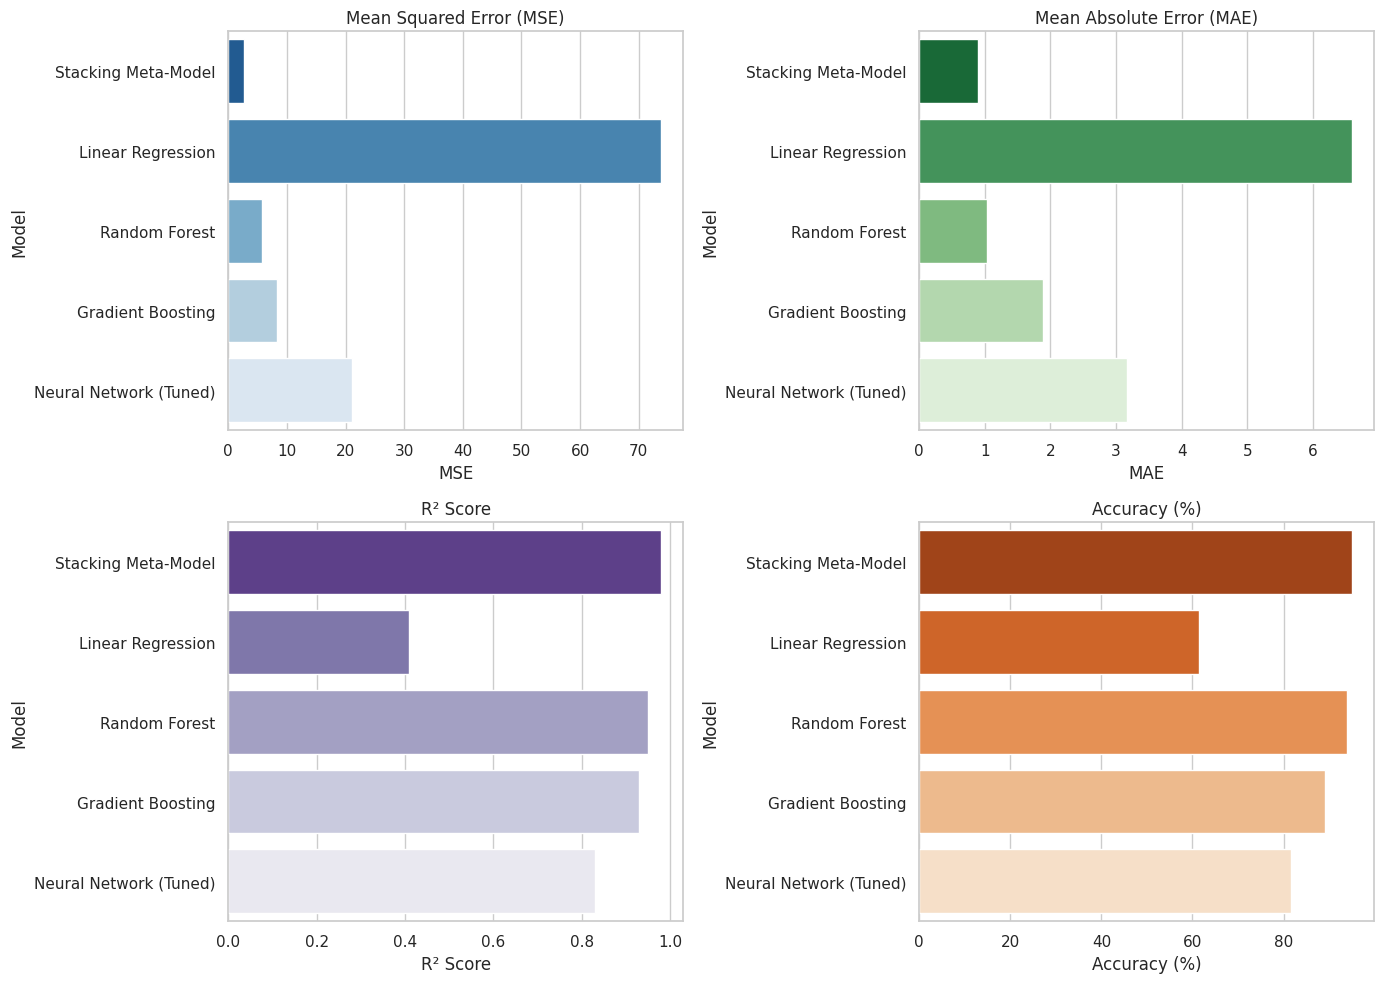

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define data
models = [
    "Stacking Meta-Model", "Linear Regression",
    "Random Forest", "Gradient Boosting", "Neural Network (Tuned)"
]
mse_values = [2.61, 73.85, 5.69, 8.28, 21.18]
mae_values = [0.90, 6.60, 1.03, 1.88, 3.16]
r2_values = [0.98, 0.41, 0.95, 0.93, 0.83]
accuracy_values = [95.12, 61.54, 93.99, 89.05, 81.57]

# Create a DataFrame for easy plotting
data = pd.DataFrame({
    "Model": models,
    "MSE": mse_values,
    "MAE": mae_values,
    "R² Score": r2_values,
    "Accuracy (%)": accuracy_values
})

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# Plot Mean Squared Error (MSE)
plt.subplot(2, 2, 1)
sns.barplot(x="MSE", y="Model", data=data, palette="Blues_r")
plt.title("Mean Squared Error (MSE)")

# Plot Mean Absolute Error (MAE)
plt.subplot(2, 2, 2)
sns.barplot(x="MAE", y="Model", data=data, palette="Greens_r")
plt.title("Mean Absolute Error (MAE)")

# Plot R² Score
plt.subplot(2, 2, 3)
sns.barplot(x="R² Score", y="Model", data=data, palette="Purples_r")
plt.title("R² Score")

# Plot Accuracy
plt.subplot(2, 2, 4)
sns.barplot(x="Accuracy (%)", y="Model", data=data, palette="Oranges_r")
plt.title("Accuracy (%)")

# Adjust layout
plt.tight_layout()
plt.show()


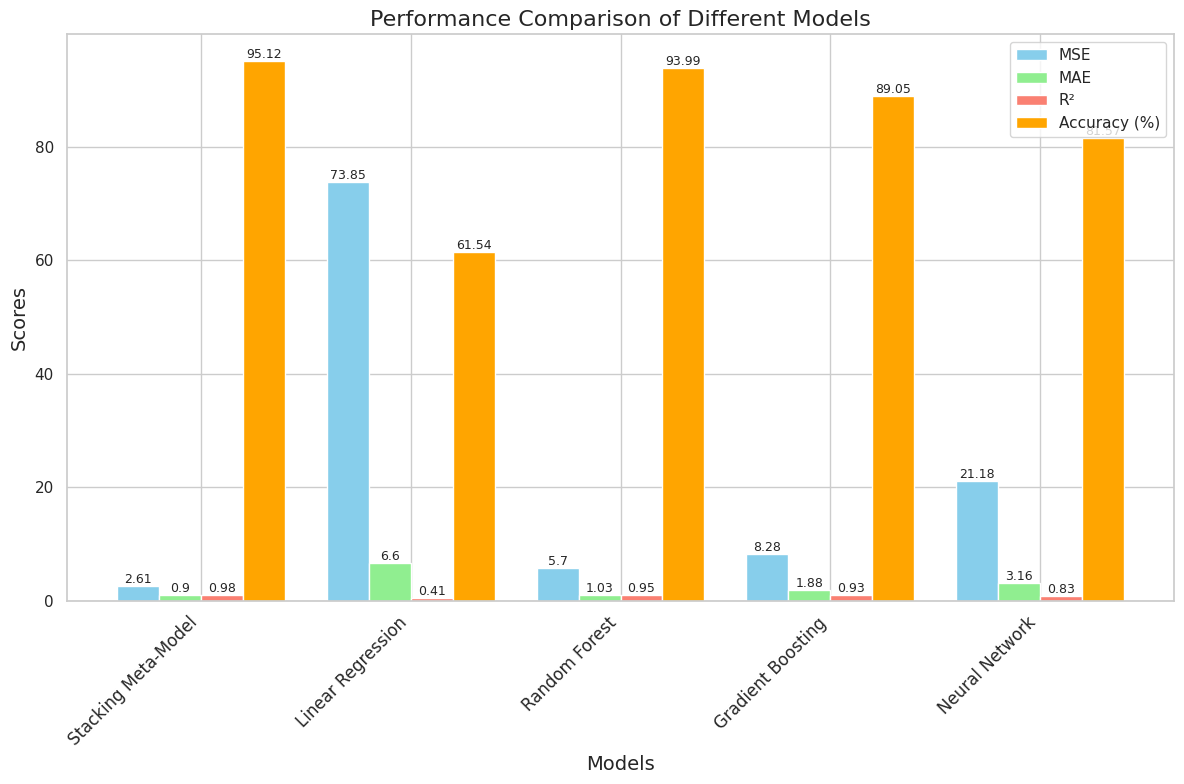

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
models = ["Stacking Meta-Model", "Linear Regression", "Random Forest", "Gradient Boosting", "Neural Network"]
mse = [2.6148, 73.8472, 5.6961, 8.2801, 21.1762]
mae = [0.9029, 6.5968, 1.0315, 1.8777, 3.1616]
r2 = [0.9806, 0.4066, 0.9542, 0.9335, 0.8298]
accuracy = [95.12, 61.54, 93.99, 89.05, 81.57]

# Set the positions and width for the bars
x = np.arange(len(models))  # label locations
width = 0.2  # width of the bars

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each metric as a separate bar
bars1 = ax.bar(x - 1.5 * width, mse, width, label='MSE', color='skyblue')
bars2 = ax.bar(x - 0.5 * width, mae, width, label='MAE', color='lightgreen')
bars3 = ax.bar(x + 0.5 * width, r2, width, label='R²', color='salmon')
bars4 = ax.bar(x + 1.5 * width, accuracy, width, label='Accuracy (%)', color='orange')

# Add labels to each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# Add additional plot settings
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_title("Performance Comparison of Different Models", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()
